In [1]:
import shutil
import torch
import os 
import re

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import F1Score
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from collections import Counter
from torchinfo import summary
from tqdm import tqdm

c:\Users\Sanya\AppData\Local\Programs\Python\Python39\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Устройство для обучения
device

device(type='cuda')

# Настройка параметров

In [20]:
LOAD_MODEL = False  # Пропустить обучение модели

# Директории с датасетами
TRAIN_PATH = 'simpsons_train'  # Путь к директории с тренировочным датасетом
TEST_PATH  = 'simpsons_test'   # Путь к директории с тестовым датасетом

# Параметры нормировки
COMPUTE_MEAN_STD = False
CHECK_MEAN_STD   = False
MEAN             = [0.4631, 0.4098, 0.3544]
STD              = [0.2536, 0.2295, 0.2617]                   

# Параметры обучения
EPOCHS = 60

# Параметры загрузчиков
BATCH_SIZE  = 64
NUM_WORKERS = 4

# Параметры оптимизатора
WEIGTH_DECAY = 5e-5
LR = 0.01

# Параметры планировщика
PATIENCE  = 5
MIN_LR    = 1e-6
THRESHOLD = 1e-4

# Параметры датасета
RESIZE   = 256  # До какого размера изменить входное изображение
CROP     = 224  # До какого размера обрезать входное изображение
VAL_SIZE = 0.1  # Доля валидационной части

# Расчет среднего и стандартного отклонения

In [13]:
def get_mean_std(loader):

    mean = torch.zeros(3)
    std  = torch.zeros(3)

    cnt = len(loader.dataset) * RESIZE ** 2

    for images, _ in tqdm(loader):

        images = images.squeeze(0)

        mean += images.sum(axis = [0, 2, 3])
        std  += (images ** 2).sum(axis = [0, 2, 3])

    mean /= cnt
    std   = torch.sqrt(std / cnt - mean ** 2) 

    return mean, std   

In [14]:
if COMPUTE_MEAN_STD:

    transform = transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        transforms.CenterCrop(CROP),
        transforms.ToTensor()])
    
    dataset = ImageFolder(TRAIN_PATH, transform = transform)
    loader  = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS)

    MEAN, STD = get_mean_std(loader)

    tqdm.write(str(MEAN))
    tqdm.write(str(STD))

100%|██████████| 295/295 [00:21<00:00, 13.95it/s]

tensor([0.4631, 0.4098, 0.3544])
tensor([0.2536, 0.2295, 0.2617])


In [16]:
 # Проверка среднего и стандартного отклонения
if CHECK_MEAN_STD:

    transform = transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        transforms.CenterCrop(CROP),
        transforms.ToTensor(),
        transforms.Normalize(mean = MEAN, std = STD)])
   
    dataset = ImageFolder(TRAIN_PATH, transform = transform)
    loader  = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS)

    mean, std = get_mean_std(loader)

    tqdm.write(str(mean))
    tqdm.write(str(std))

100%|██████████| 295/295 [00:19<00:00, 15.08it/s]

tensor([ 3.3083e-07, -5.4480e-07, -9.0693e-07])
tensor([1.0000, 1.0000, 1.0000])


# Настройка аугментаций

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.CenterCrop(CROP),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),   
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.3, contrast = 0.1),
        transforms.GaussianBlur(5)], 
        p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean = MEAN, std = STD)])

test_transform = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.CenterCrop(CROP),
    transforms.ToTensor(),
    transforms.Normalize(mean = MEAN, std = STD)])

## Подготовка тестового датасета

In [5]:
files = os.listdir(TEST_PATH)

for file in files: 

    if os.path.isdir(os.path.join(TEST_PATH, file)): # Пропустить все папки в директории
        continue

    match = re.search(r'[a-z_]+', file) # Отобрать от названия файлов только имена персонажей

    if match != None:

        name = match.group(0)[:-1] # Обрезать последнее нижнее подчеркивание

        if not os.path.exists(os.path.join(TEST_PATH, name)): # Создать папку с именем персонажа, если она ещё не существует        
            os.mkdir(os.path.join(TEST_PATH, name))

        shutil.move(os.path.join(TEST_PATH, file), os.path.join(TEST_PATH, name)) # Перенести все изображения с именем персонажа в созданную папку

## Создание датасетов

In [21]:
# Создание датасетов
dataset      = ImageFolder(TRAIN_PATH, transform = train_transform)
test_dataset = ImageFolder(TEST_PATH, transform = test_transform)

n_val   = int(np.floor(VAL_SIZE * len(dataset))) # Количество изображений в валидационном датасете
n_train = len(dataset) - n_val                   # Количество изображений в тренировочном датасете
n_test  = len(test_dataset)                      # Количество изображений в тестовом датасете

# Разделение тренировочного датасета для получения валидационного
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

## Нахождение весов каждого класса

In [7]:
ids = train_dataset.indices              # Индексы изображений в датасете
nums = [dataset.targets[i] for i in ids] # Сопоставить каждому индексу изображений соответсвующий номер класса

samples = list(Counter(sorted(nums)).values()) # Количество изображений в каждом классе

weights = [samples[i] / sum(samples) for i in range(len(samples))] # Веса каждого класса
weights = torch.FloatTensor(weights)

## Создание тренировочного, валидационного и тестового загрузчиков 

In [22]:
# Создание загрузчиков
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
valid_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
test_loader  = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)

# Классы в датасетах
train_classes = dataset.classes
test_classes  = test_dataset.classes

# Сопоставить номера классов тестового датасета с номерами
# тренировочного датасета
classes_dict = {test_dataset.class_to_idx[cls] : dataset.class_to_idx[cls]  for cls in test_classes}

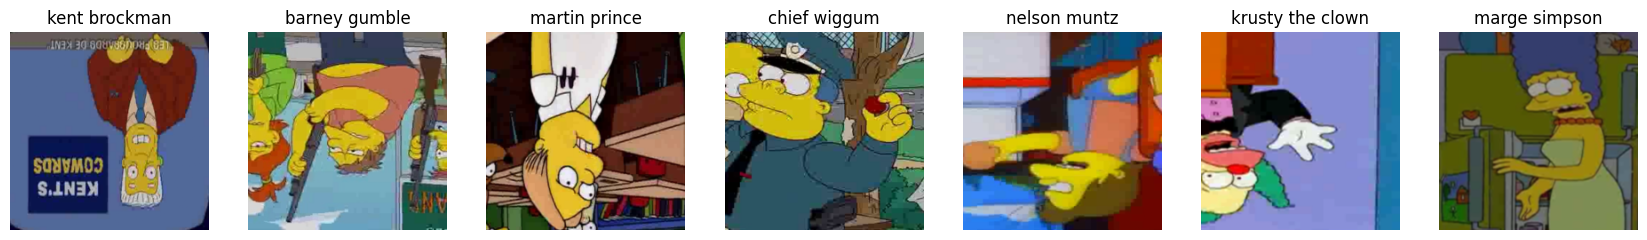

In [17]:
# Вывод заданного количества изображений
def imshow(images, labels, cnt):

    # Подготовка холста для изображений
    fig, axs = plt.subplots(1, cnt) 
    fig.set_figwidth(cnt * 3)

    for i, image in enumerate(images[:cnt]):
        
        # Разнормировать изображения
        for chn in range(3):
            image[chn] = image[chn] * STD[chn] + MEAN[chn]

        # Приведение массива к формату (H, W, Ch)
        npimg = image.numpy()
        npimg = np.transpose(npimg, (1, 2, 0)).squeeze()

        ax = axs[i] if cnt > 1 else axs

        # Вывод изображения
        ax.set_title(train_classes[labels[i]].replace('_', ' '))
        ax.set_axis_off()
        ax.imshow(npimg)

    plt.show()
   
# Получить случайные тренировочные изображения
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(images, labels, 7)

## Создание модели

In [10]:
model = resnet50(weights = None)

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace = True),
    nn.Linear(128, len(train_classes)))

model.to(device)

# Загрузить сохраненные веса в модель
if LOAD_MODEL:
    model.load_state_dict(torch.load('weights.htp'))

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss(weight = weights).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = LR, weight_decay = WEIGTH_DECAY)
schedule = ReduceLROnPlateau(optimizer, patience = PATIENCE, min_lr = MIN_LR, threshold = THRESHOLD)

#summary(net, input_size = (batch_size, 3, size, size))

# Обучение модели

In [11]:
if not LOAD_MODEL:

    # Значения функции потерь в течение обучения
    train_losses = np.zeros(EPOCHS) 
    val_losses   = np.zeros(EPOCHS)

    # Значения F1 в течение обучения
    train_f1s = np.zeros(EPOCHS) 
    val_f1s   = np.zeros(EPOCHS)

    # Значения learning rate в течение обучения
    lrs = []

    for epoch in (pbar := tqdm(range(EPOCHS))):
        
        torch.save(model.state_dict(), 'weights.htp')
        best_f1 = 0

        train_f1 = F1Score(task = 'multiclass', num_classes = len(train_classes), average = 'macro').to(device)
        val_f1   = F1Score(task = 'multiclass', num_classes = len(train_classes), average = 'none').to(device)

        model.train()

        for images, labels in train_loader:  

            # Отправить тензоры на выбранное устройство для обучения
            images = images.to(device)
            labels = labels.to(device)
            
            # Прямой проход
            outputs = model(images)
            loss = criterion(outputs, labels)           
            train_losses[epoch] += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            train_f1.update(predicted, labels)

            # Обратный проход и оптимизация
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            lrs.append(optimizer.param_groups[0]["lr"])           

        train_f1s[epoch] = 100 * train_f1.compute()
        train_losses[epoch] /= len(train_loader)  
        
        # Валидация
        with torch.no_grad():

            model.eval()

            for images, labels in valid_loader:

                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_losses[epoch] += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                
                val_f1.update(predicted, labels)

            val_losses[epoch] /= len(valid_loader)
            val_f1s[epoch] = 100 * sum(val_f1.compute()) / val_f1.compute().count_nonzero()

            # Сохранение весов, если результат на текущей эпохе лучше
            if best_f1 < val_f1s[epoch]:
                best_f1 = val_f1s[epoch]
                torch.save(model.state_dict(), 'weights.htp')

        schedule.step(val_losses[epoch])
        pbar.set_description(f'Avg. train/valid loss: [{train_losses[epoch].item():.2f}/{val_losses[epoch].item():.2f}], train/valid F1: [{train_f1s[epoch]:.2f}%/{val_f1s[epoch]:.2f}%]')

    # Загрузка и сохранение лучших весов
    model.load_state_dict(torch.load('weights.htp'))

Avg. train/valid loss: [0.02/0.32], train/valid F1: [69.49%/81.19%]: 100%|██████████| 60/60 [1:34:03<00:00, 94.06s/it]


## Графики

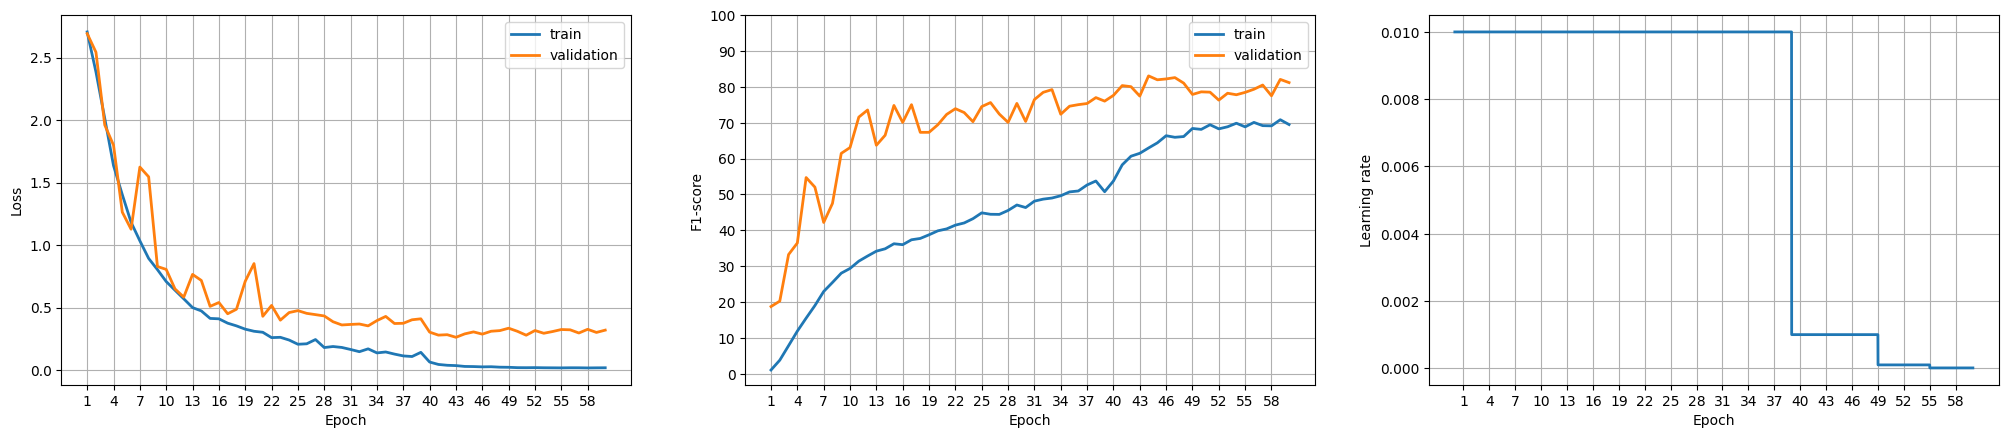

In [24]:
step = 3

fig, axs = plt.subplots(1, 3)
fig.set_figwidth(25) 

axs[0].plot(range(1, EPOCHS + 1), train_losses, linewidth = 2, label = 'train')
axs[0].plot(range(1, EPOCHS + 1), val_losses, linewidth = 2, label = 'validation')
axs[0].set_xticks(range(1, EPOCHS + 1, step))
axs[0].set_xlabel('Epoch') 
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

axs[1].plot(range(1, EPOCHS + 1), train_f1s, linewidth = 2, label = 'train')
axs[1].plot(range(1, EPOCHS + 1), val_f1s, linewidth = 2, label = 'validation')
axs[1].set_xticks(range(1, EPOCHS + 1, step))
axs[1].set_yticks(range(0, 101, 10))
axs[1].set_xlabel('Epoch') 
axs[1].set_ylabel('F1-score')
axs[1].legend()
axs[1].grid()

axs[2].plot(np.linspace(0, EPOCHS, len(lrs)), lrs, linewidth = 2)
axs[2].set_xticks(range(1, EPOCHS + 1, step))
axs[2].set_xlabel('Epoch') 
axs[2].set_ylabel('Learning rate')
axs[2].grid()

plt.show()

# Тестирование модели

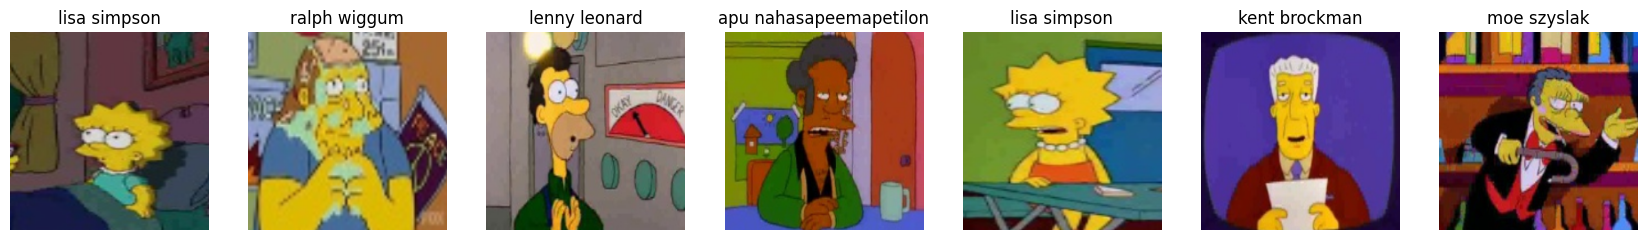

F1-score of the network on the 991 testing images: 90.8641 %


In [23]:
f1 = F1Score(task = 'multiclass', num_classes = len(train_classes), average = 'none').to(device)
model.eval()

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        labels = labels.apply_(lambda num: classes_dict[num]) # Перевести номера тренировочных меток в номера тестовых меток
        labels = labels.to(device)

        f1.update(predicted, labels)
        
        # Отобразить изображения с предсказанными названиями
        if not i:
            imshow(images.cpu(), predicted.cpu(), 7)

    print('F1-score of the network on the {} testing images: {:.4f} %'.format(n_test, 100 * sum(f1.compute()) / len(test_classes)))